# Test 12 & 13: Prediction with Full Covariance Matrix for increasing problem size

These test capture the runtime for the Prediction with Full Covariance Matrix with GPRat, GPyTorch, GPflow on the CPU and GPU.
We use an increasing problem size in $\{2^6, \dots, 2^{16}\}$, an fixed number of tiles of XY for CPU and XY for GPU for GPRat, a fixed number of cores of $48$, 8 regressors, an fixed number of CUDA streams of XY for GPRat, and loop 11 times (first loop is ignored of warmup).

Findings:

- ...

In [1]:
# setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import utils
import math

import warnings

warnings.filterwarnings("ignore")

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams["font.family"] = "STIXGeneral"
mpl.rcParams.update({"font.size": 11})
mpl.rcParams.update({"errorbar.capsize": 7})
mpl.rcParams.update({"grid.linewidth": 0.5})
mpl.rcParams.update({"legend.fontsize": 9})
mpl.rcParams.update({"lines.markersize": 6})


def figsize(x, y, y_log_min=1, y_log_max=1):
    """
    Set figsize based on same bounding box to achive shared axes
    """
    x_const = 0.5847574256049264
    y_const = 0.43668402777777837
    return (
        x + x_const,
        (y + math.log10(y_log_max) - math.log10(y_log_min)) * 0.5 + y_const,
    )


# bbox = ax.get_position()
# fig_width, fig_height = fig.get_size_inches()
# print((1 - (bbox.x1 - bbox.x0)) * fig_width, (1 - (bbox.y1 - bbox.y0)) * fig_height)

In [2]:
# load data

apex_dir_pfc_gprat = "./data/7/gprat/"
apex_dir_pfc_gprat_steps = "./data/8/"
subdirs = ["apex-cpu/", "apex-gpu/"]

names_steps = [
    "predict_full_cov_step ressource allocation",
    "predict_full_cov_step assembly",
    "predict_full_cov_step cholesky",
    "predict_full_cov_step forward",
    "predict_full_cov_step backward",
    "predict_full_cov_step forward KcK",
    "predict_full_cov_step prediction",
    "predict_full_cov_step full cov",
    "predict_full_cov_step pred uncer",
    "predict_full_cov_step copyback",
    "predict_full_cov_step ressource destroy",
    "assemble K_tiles",
    "assemble alpha_tiles",
    "assemble prior_K_tiles_full",
    "assemble cross_covariance_tiles",
    "assemble t_cross_covariance_tiles",
    "assemble zeros",
    "cholesky potrf",
    "cholesky trsm",
    "cholesky syrk",
    "cholesky gemm",
    "forward trsv",
    "forward gemv",
    "backward trsv",
    "backward gemv",
    "forward_KcK trsm",
    "forward_KcK gemm",
    "predict gemv",
    "full_cov gemm",
    "pred_uncer diag_tile",
]

file_headers_cpu = ["n_cores", "n_train", "n_test", "n_tiles", "n_reg", "n_loops"]
file_headers_gpu = ["n_cores", "n_train", "n_test", "n_tiles", "n_reg", "n_streams", "n_loops"]


def apex_files_to_df(dir, names, file_headers):
    data = []
    for filename in os.listdir(dir):
        if filename.endswith(".csv"):
            parts = (
                filename.replace("apex_profiles_", "").replace(".csv", "").split("_")
            )
            file_params = dict(zip(file_headers, map(int, parts)))
            file_path = os.path.join(dir, filename)
            df = pd.read_csv(file_path)
            df = df[df["name"].isin(names)]
            for key, value in file_params.items():
                df[key] = value
            data.append(df)
    df_combined = pd.concat(data, ignore_index=True)
    df_combined = df_combined.sort_values(by=["n_train", "n_tiles"])
    return df_combined

df_pfc_gprat_steps = []

df_pfc_gprat_steps.append(
    apex_files_to_df(apex_dir_pfc_gprat_steps + subdirs[0], names_steps, file_headers_cpu)
)
df_pfc_gprat_steps.append(
    apex_files_to_df(
        apex_dir_pfc_gprat_steps + subdirs[1], names_steps, file_headers_gpu
    )
)

In [3]:
def mean_stddev(df, groupby_cols):
    new_df = df[df["i_loop"] != 0]
    new_df = (
        new_df.groupby(groupby_cols)["time"].agg(["mean", "std", "count"]).reset_index()
    )
    new_df.rename(columns={'std': 'stddev', 'count': 'n_loops'}, inplace=True)
    return new_df

In [4]:
df_gprat_cpu = pd.read_csv("./data/7/gprat/output-cpu.csv")
df_gprat_cpu = mean_stddev(df_gprat_cpu, ["n_cores", "n_train", "n_test", "n_tiles", "n_reg"])

df_gprat_gpu = pd.read_csv("./data/7/gprat/output-gpu.csv")
df_gprat_gpu = mean_stddev(df_gprat_gpu, ["n_cores", "n_train", "n_test", "n_tiles", "n_reg"])

df_pfc_gprat = [df_gprat_cpu, df_gprat_gpu]

df_gpytorch_cpu = pd.read_csv("./data/7/gpytorch3/output-cpu.csv")
df_gpytorch_cpu = mean_stddev(
    df_gpytorch_cpu, ["n_cores", "n_train", "n_test", "n_reg"]
)

df_gpytorch_gpu = pd.read_csv("./data/7/gpytorch3/output-gpu.csv")
df_gpytorch_gpu = mean_stddev(
    df_gpytorch_gpu, ["n_cores", "n_train", "n_test", "n_reg"]
)

df_gpytorch = [df_gpytorch_cpu, df_gpytorch_gpu]

df_gpytorch_cpu2 = pd.read_csv("./data/7/gpytorch2/output-cpu.csv")
df_gpytorch_cpu2 = mean_stddev(
    df_gpytorch_cpu2, ["n_cores", "n_train", "n_test", "n_reg"]
)

df_gpytorch_gpu2 = pd.read_csv("./data/7/gpytorch2/output-gpu.csv")
df_gpytorch_gpu2 = mean_stddev(
    df_gpytorch_gpu2, ["n_cores", "n_train", "n_test", "n_reg"]
)

df_gpytorch2 = [df_gpytorch_cpu2, df_gpytorch_gpu2]

df_gpflow_cpu = pd.read_csv("./data/7/gpflow/output-cpu.csv")
df_gpflow_cpu = mean_stddev(df_gpflow_cpu, ["n_cores", "n_train", "n_test", "n_reg"])

df_gpflow_gpu = pd.read_csv("./data/7/gpflow/output-gpu.csv")
df_gpflow_gpu = mean_stddev(df_gpflow_gpu, ["n_cores", "n_train", "n_test", "n_reg"])

df_gpflow = [df_gpflow_cpu, df_gpflow_gpu]

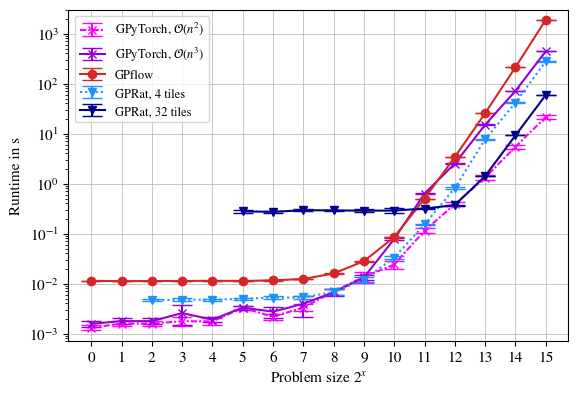

In [33]:
# plot for predict-fullcov GPRat, GPyTorch, GPflow on CPU

plt.figure(figsize=figsize(5, 7, 7, 3))

plt.xlabel("Problem size $2^x$")
plt.ylabel("Runtime in s")
plt.grid(True, which="both")
plt.grid(False, which="minor")
plt.xscale("log", base=2)
plt.yscale("log", base=10)
plt.ylim(7*10**-4, 3 * 10**3)

xticks = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
plt.xticks(
    xticks,
    [f"{int(np.log2(nt))}" for nt in xticks],
)

label = r"GPyTorch, $\mathcal{O}(n^2)$"
df_gpytorch_target = df_gpytorch2[0]
err = utils.confidence_error(df_gpytorch_target)
plt.errorbar(
    df_gpytorch_target["n_train"],
    df_gpytorch_target["mean"],
    yerr=err,
    label=label,
    color="magenta",
    marker="x",
    linestyle=(0, (3, 1, 1, 1)),
)

label = "GPyTorch, $\mathcal{O}(n^3)$"
df_gpytorch_target = df_gpytorch[0]
err = utils.confidence_error(df_gpytorch_target)
plt.errorbar(
    df_gpytorch_target["n_train"],
    df_gpytorch_target["mean"],
    yerr=err,
    label=label,
    color="darkviolet",
    marker="x",
)

label = "GPflow"
df_gpflow_target = df_gpflow[0]
err = utils.confidence_error(df_gpflow_target)
plt.errorbar(
    df_gpflow_target["n_train"],
    df_gpflow_target["mean"],
    yerr=err,
    label=label,
    color="tab:red",
    marker="o"
)

label = r"GPRat"
ls = [(0, (1, 1.5)), "-"]
df_gprat_target = df_pfc_gprat[0]
for n_tiles, c, l in zip(df_gprat_target["n_tiles"].unique(), ["dodgerblue", "darkblue"], ls):
    df_gprat_target_n_tiles = df_gprat_target[df_gprat_target["n_tiles"] == n_tiles]
    err = utils.confidence_error(df_gprat_target_n_tiles)
    plt.errorbar(
        df_gprat_target_n_tiles["n_train"],
        df_gprat_target_n_tiles["mean"],
        yerr=err,
        label=f"{label}, {n_tiles} {"tile" if n_tiles == 1 else "tiles"}",
        color=c,
        marker="v",
        linestyle=l
    )

plt.legend()
plt.tight_layout(pad=0)

plt.savefig("./pdf/predict-fullcov-cpu-inc.pdf")

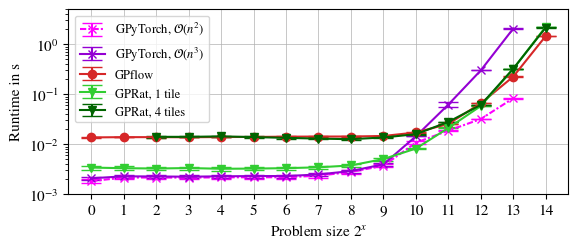

In [6]:
# plot for predict-fullcov GPRat, GPyTorch, GPflow on GPU

plt.figure(figsize=figsize(5, 3, 1, 5))

plt.xlabel("Problem size $2^x$")
plt.ylabel("Runtime in s")
plt.grid(True, which="both")
plt.grid(False, which="minor")
plt.xscale("log", base=2)
plt.yscale("log", base=10)
plt.ylim(10**-3, 5 * 10**0)

xticks = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
plt.xticks(
    xticks,
    [f"{int(np.log2(nt))}" for nt in xticks],
)

label = r"GPyTorch, $\mathcal{O}(n^2)$"
df_gpytorch_target = df_gpytorch2[1]
err = utils.confidence_error(df_gpytorch_target)
plt.errorbar(
    df_gpytorch_target["n_train"],
    df_gpytorch_target["mean"],
    yerr=err,
    label=label,
    color="magenta",
    linestyle=(0, (3,1,1,1)),
    marker="x"
)

label = "GPyTorch, $\mathcal{O}(n^3)$"
df_gpytorch_target = df_gpytorch[1]
err = utils.confidence_error(df_gpytorch_target)
plt.errorbar(
    df_gpytorch_target["n_train"],
    df_gpytorch_target["mean"],
    yerr=err,
    label=label,
    color="darkviolet",
    marker="x"
)


label = "GPflow"
df_gpflow_target = df_gpflow[1]
err = utils.confidence_error(df_gpflow_target)
plt.errorbar(
    df_gpflow_target["n_train"],
    df_gpflow_target["mean"],
    yerr=err,
    label=label,
    color="tab:red",
    marker="o"
)

label = r"GPRat"
df_gprat_target = df_pfc_gprat[1]
for n_tiles, c in zip(
    df_gprat_target["n_tiles"].unique(), ["limegreen", "darkgreen"]
):
    df_gprat_target_n_tiles = df_gprat_target[df_gprat_target["n_tiles"] == n_tiles]
    err = utils.confidence_error(df_gprat_target_n_tiles)
    plt.errorbar(
        df_gprat_target_n_tiles["n_train"],
        df_gprat_target_n_tiles["mean"],
        yerr=err,
        label=f"{label}, {n_tiles} {"tile" if n_tiles == 1 else "tiles"}",
        color=c,
        marker="v"
    )

plt.legend()
plt.tight_layout(pad=0)

plt.savefig("./pdf/predict-fullcov-gpu-inc.pdf")

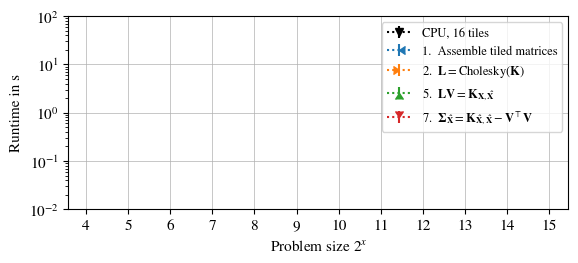

In [32]:
# plot for predict-fullcov steps for GPRat

plt.figure(figsize=figsize(5, 4))

plt.xlabel("Problem size $2^x$")
plt.ylabel("Runtime in s")
plt.grid(True, which="both")
plt.grid(False, which="minor")
plt.xscale("log", base=2)
plt.yscale("log", base=10)
plt.xlim(12, 45000)
plt.ylim(10**-2, 10**2)

xticks = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
plt.xticks(
    xticks,
    [f"{int(np.log2(nt))}" for nt in xticks],
)

df_name_target = df_gprat_cpu[df_gprat_cpu["n_tiles"] == 16]
err = utils.confidence_error(df_name_target)
plt.errorbar(
    df_name_target["n_train"],
    df_name_target["mean"],
    yerr=err,
    label="CPU, 16 tiles",
    color="black",
    linestyle=(0, (1, 1.5)),
    marker="v"
)

names = [
    "predict_full_cov_step assembly",
    "predict_full_cov_step cholesky",
    # "predict_full_cov_step forward",
    # "predict_full_cov_step backward",
    "predict_full_cov_step forward KcK",
    # "predict_full_cov_step prediction",
    "predict_full_cov_step full cov",
    "predict_full_cov_step pred uncer",
]

labels = [
    r"1.  Assemble tiled matrices",
    r"2.  $\mathbf{L} = \text{Cholesky}(\mathbf{K})$",
    # r"3.  $\mathbf{L\beta} = \mathbf{y}$",
    # r"4.  $\mathbf{L^\top\alpha} = \mathbf{\beta}$",
    r"5.  $\mathbf{LV} = \mathbf{K}_{\mathbf{X},\mathbf{\hat X}}$",
    # r"6.  $\mathbf{\hat y} = \mathbf{K}_{\mathbf{\hat X},\mathbf{X}}\mathbf{\alpha}$",
    r"7.  $\mathbf{\Sigma}_{\mathbf{\hat X}} = \mathbf{K}_{\mathbf{\hat X},\mathbf{\hat X}} - \mathbf{V}^\top \mathbf{V}$",
]

df_steps_cpu = df_pfc_gprat_steps[0][df_pfc_gprat_steps[0]["n_tiles"] == 16]
for name, label, c, marker in zip(names, labels, ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink"], [4,5,6,7]):
    df_name_target = df_steps_cpu[df_steps_cpu["name"] == name]
    err = utils.confidence_error(df_name_target, 0.95)
    plt.errorbar(
        df_name_target["n_train"],
        df_name_target["mean"] / 10**9,
        yerr=err / 10**9,
        label=label,
        color=c,
        linestyle=(0, (1, 1.5)),
        marker=marker,
    )

plt.legend()
plt.tight_layout(pad=0)

plt.savefig("./pdf/predict-fullcov-steps-large-cpu.pdf")

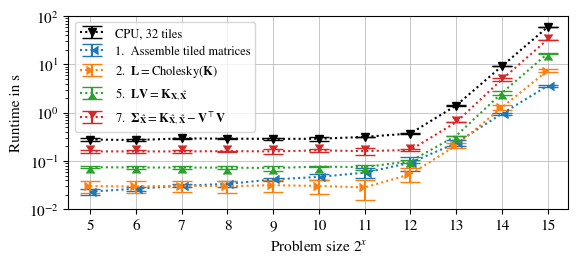

In [17]:
# plot for predict-fullcov steps for GPRat

plt.figure(figsize=figsize(5, 4))

plt.xlabel("Problem size $2^x$")
plt.ylabel("Runtime in s")
plt.grid(True, which="both")
plt.grid(False, which="minor")
plt.xscale("log", base=2)
plt.yscale("log", base=10)
plt.xlim(23, 45000)
plt.ylim(10**-2, 10**2)

xticks = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
plt.xticks(
    xticks,
    [f"{int(np.log2(nt))}" for nt in xticks],
)

df_name_target = df_gprat_cpu[df_gprat_cpu["n_tiles"] == 32]
err = utils.confidence_error(df_name_target)
plt.errorbar(
    df_name_target["n_train"],
    df_name_target["mean"],
    yerr=err,
    label="CPU, 32 tiles",
    color="black",
    linestyle=(0, (1, 1.5)),
    marker="v",
)

names = [
    "predict_full_cov_step assembly",
    "predict_full_cov_step cholesky",
    # "predict_full_cov_step forward",
    # "predict_full_cov_step backward",
    "predict_full_cov_step forward KcK",
    # "predict_full_cov_step prediction",
    "predict_full_cov_step full cov",
    "predict_full_cov_step pred uncer",
]

labels = [
    r"1.  Assemble tiled matrices",
    r"2.  $\mathbf{L} = \text{Cholesky}(\mathbf{K})$",
    # r"3.  $\mathbf{L\beta} = \mathbf{y}$",
    # r"4.  $\mathbf{L^\top\alpha} = \mathbf{\beta}$",
    r"5.  $\mathbf{LV} = \mathbf{K}_{\mathbf{X},\mathbf{\hat X}}$",
    # r"6.  $\mathbf{\hat y} = \mathbf{K}_{\mathbf{\hat X},\mathbf{X}}\mathbf{\alpha}$",
    r"7.  $\mathbf{\Sigma}_{\mathbf{\hat X}} = \mathbf{K}_{\mathbf{\hat X},\mathbf{\hat X}} - \mathbf{V}^\top \mathbf{V}$",
]

df_steps_cpu = df_pfc_gprat_steps[0][df_pfc_gprat_steps[0]["n_tiles"] == 32]
for name, label, c, marker in zip(
    names,
    labels,
    [
        "tab:blue",
        "tab:orange",
        "tab:green",
        "tab:red",
        "tab:purple",
        "tab:brown",
        "tab:pink",
    ],
    [4, 5, 6, 7],
):
    df_name_target = df_steps_cpu[df_steps_cpu["name"] == name]
    err = utils.confidence_error(df_name_target, 0.95)
    plt.errorbar(
        df_name_target["n_train"],
        df_name_target["mean"] / 10**9,
        yerr=err / 10**9,
        label=label,
        color=c,
        linestyle=(0, (1, 1.5)),
        marker=marker,
    )

plt.legend()
plt.tight_layout(pad=0)

plt.savefig("./pdf/predict-fullcov-steps-large-gpu.pdf")

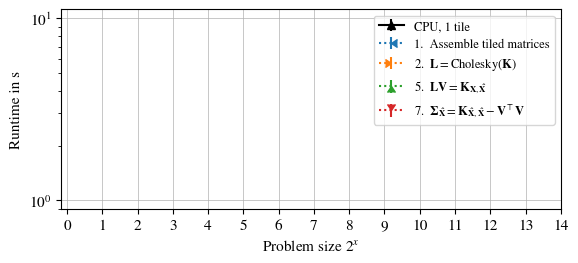

In [31]:
# plot for predict-fullcov steps for GPRat

plt.figure(figsize=figsize(5, 4))

plt.xlabel("Problem size $2^x$")
plt.ylabel("Runtime in s")
plt.grid(True, which="both")
plt.grid(False, which="minor")
plt.xscale("log", base=2)
plt.yscale("log", base=10)
# plt.xlim(0.7, 30000)
# plt.ylim(10**-5, 10 * 10**1)

xticks = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
plt.xticks(
    xticks,
    [f"{int(np.log2(nt))}" for nt in xticks],
)

df_name_target = df_gprat_cpu[df_gprat_cpu["n_tiles"] == 1]
err = utils.confidence_error(df_name_target)
plt.errorbar(
    df_name_target["n_train"],
    df_name_target["mean"],
    yerr=err,
    label="CPU, 1 tile",
    color="black",
    marker="^",
)

names = [
    "predict_full_cov_step assembly",
    "predict_full_cov_step cholesky",
    # "predict_full_cov_step forward",
    # "predict_full_cov_step backward",
    "predict_full_cov_step forward KcK",
    # "predict_full_cov_step prediction",
    "predict_full_cov_step full cov",
    "predict_full_cov_step pred uncer",
]

labels = [
    r"1.  Assemble tiled matrices",
    r"2.  $\mathbf{L} = \text{Cholesky}(\mathbf{K})$",
    # r"3.  $\mathbf{L\beta} = \mathbf{y}$",
    # r"4.  $\mathbf{L^\top\alpha} = \mathbf{\beta}$",
    r"5.  $\mathbf{LV} = \mathbf{K}_{\mathbf{X},\mathbf{\hat X}}$",
    # r"6.  $\mathbf{\hat y} = \mathbf{K}_{\mathbf{\hat X},\mathbf{X}}\mathbf{\alpha}$",
    r"7.  $\mathbf{\Sigma}_{\mathbf{\hat X}} = \mathbf{K}_{\mathbf{\hat X},\mathbf{\hat X}} - \mathbf{V}^\top \mathbf{V}$",
]

df_steps_cpu = df_pfc_gprat_steps[0][df_pfc_gprat_steps[0]["n_tiles"] == 1]
for name, label, c, marker in zip(
    names,
    labels,
    [
        "tab:blue",
        "tab:orange",
        "tab:green",
        "tab:red",
        "tab:purple",
        "tab:brown",
        "tab:pink",
    ],
    [4, 5, 6, 7],
):
    df_name_target = df_steps_cpu[df_steps_cpu["name"] == name]
    err = utils.confidence_error(df_name_target, 0.95)
    plt.errorbar(
        df_name_target["n_train"],
        df_name_target["mean"] / 10**9,
        yerr=err / 10**9,
        label=label,
        color=c,
        linestyle=(0, (1, 1.5)),
        marker=marker,
    )

plt.legend()
plt.tight_layout(pad=0)

plt.savefig("./pdf/predict-fullcov-steps-small-cpu.pdf")

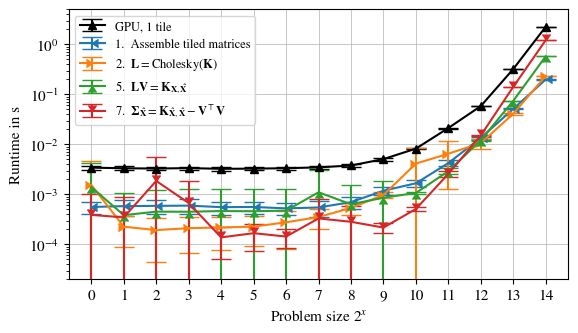

In [22]:
# plot for predict-fullcov steps for GPRat

plt.figure(figsize=figsize(5, 6, 2, 0.5))

plt.xlabel("Problem size $2^x$")
plt.ylabel("Runtime in s")
plt.grid(True, which="both")
plt.grid(False, which="minor")
plt.xscale("log", base=2)
plt.yscale("log", base=10)
# plt.xlim(0.7, 30000)
plt.ylim(2*10**-5, 0.5*10**1)

xticks = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
plt.xticks(
    xticks,
    [f"{int(np.log2(nt))}" for nt in xticks],
)

names = [
    "predict_full_cov_step assembly",
    "predict_full_cov_step cholesky",
    # "predict_full_cov_step forward",
    # "predict_full_cov_step backward",
    "predict_full_cov_step forward KcK",
    # "predict_full_cov_step prediction",
    "predict_full_cov_step full cov",
    "predict_full_cov_step pred uncer",
]

labels = [
    r"1.  Assemble tiled matrices",
    r"2.  $\mathbf{L} = \text{Cholesky}(\mathbf{K})$",
    # r"3.  $\mathbf{L\beta} = \mathbf{y}$",
    # r"4.  $\mathbf{L^\top\alpha} = \mathbf{\beta}$",
    r"5.  $\mathbf{LV} = \mathbf{K}_{\mathbf{X},\mathbf{\hat X}}$",
    # r"6.  $\mathbf{\hat y} = \mathbf{K}_{\mathbf{\hat X},\mathbf{X}}\mathbf{\alpha}$",
    r"7.  $\mathbf{\Sigma}_{\mathbf{\hat X}} = \mathbf{K}_{\mathbf{\hat X},\mathbf{\hat X}} - \mathbf{V}^\top \mathbf{V}$",
]

df_name_target = df_gprat_gpu[df_gprat_gpu["n_tiles"] == 1]
err = utils.confidence_error(df_name_target)
plt.errorbar(
    df_name_target["n_train"],
    df_name_target["mean"],
    yerr=err,
    label="GPU, 1 tile",
    color="black",
    marker="^",
)

df_steps_gpu = df_pfc_gprat_steps[1][df_pfc_gprat_steps[1]["n_tiles"] == 1]
for name, label, c, marker in zip(
    names,
    labels,
    [
        "tab:blue",
        "tab:orange",
        "tab:green",
        "tab:red",
        # "tab:purple",
        # "tab:brown",
        # "tab:pink",
    ],
    [4, 5, 6, 7],
):
    df_name_target = df_steps_gpu[df_steps_gpu["name"] == name]
    err = utils.confidence_error(df_name_target, 0.95)
    plt.errorbar(
        df_name_target["n_train"],
        df_name_target["mean"] / 10**9,
        yerr=err / 10**9,
        label=label,
        color=c,
        marker=marker,
    )

plt.legend()
plt.tight_layout(pad=0)

plt.savefig("./pdf/predict-fullcov-steps-small-gpu.pdf")